In [1]:
# Standard Library Imports
import os
import tarfile
import json
import time

# Third-Party Library Imports
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
import wandb
from PIL import ImageOps

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# PyTorch-related Libraries
from torchvision import transforms
from segmentation_models_pytorch import Unet
from torchvision.transforms import Resize, Pad
from torchvision.transforms import functional as TF
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import InterpolationMode

In [2]:
num_epochs = 10

wandb.init(
    project="Deep-Learning-Exam",
    name="augmentation-flip-model",
    dir="./wandb_logs",
    config={
        "version": "v1.0.0",
        "learning_rate": 1e-4,
        "architecture": "UNet",
        "encoder": "resnet34",
        "dataset": "Kvasir-Instrument",
    },
    settings=wandb.Settings(init_timeout=900)
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: richardhansen (richardhansen-kristiania-university-college). Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./wandb_logs\wandb\ wasn't writable, using system temp directory.


In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

print(f"Using device: {device}")


PyTorch Version: 2.4.1+cu118
CUDA Available: True
CUDA Version: 11.8
GPU Name: NVIDIA GeForce RTX 4090
Using device: cuda


In [4]:
# Define dataset paths
dataset_dir = '../../data/kvasir-instrument'
images_tar = os.path.join(dataset_dir, 'images.tar.gz')
masks_tar = os.path.join(dataset_dir, 'masks.tar.gz')
train_txt = os.path.join(dataset_dir, 'train.txt')
test_txt = os.path.join(dataset_dir, 'test.txt')
images_dir = os.path.join(dataset_dir, 'images')
masks_dir = os.path.join(dataset_dir, 'masks')
bbox_json = os.path.join(dataset_dir, 'bboxes.json')

# Function to extract tar.gz files
def extract_tar(tar_path, extract_path):
    if not os.path.exists(extract_path):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
            print(f"Extracted {tar_path} to {extract_path}.")
    else:
        print(f"Directory {extract_path} already exists. Skipping extraction.")

# Function to load file splits
def load_split(file_path):
    return [line.strip() for line in open(file_path, 'r')] if os.path.exists(file_path) else []

# Verify files based on splits
def verify_files(filenames, directory, extensions=('.jpg', '.jpeg', '.png')):
    return [os.path.join(directory, f + ext) for f in filenames for ext in extensions if os.path.exists(os.path.join(directory, f + ext))]

# Extract dataset
extract_tar(images_tar, images_dir)
extract_tar(masks_tar, masks_dir)

# Load train and test splits
train_filenames = load_split(train_txt)
test_filenames = load_split(test_txt)

# Load bboxes.json
with open(bbox_json, 'r') as f:
    bboxes = json.load(f)



Directory ../../data/kvasir-instrument\images already exists. Skipping extraction.
Directory ../../data/kvasir-instrument\masks already exists. Skipping extraction.


In [5]:
def flip_image_and_mask(image, mask):
    """Horizontally flip image and mask."""
    image = TF.hflip(image)
    mask = TF.hflip(mask)
    return image, mask

In [6]:
class KvasirInstrumentDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_ids, target_size=(576, 576), augment=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.resize_to_target = Resize(self.target_size)
        self.augment = augment

        # Define the available transformations
        self.transforms = ['flip']

        if self.augment:
            # Create a list of (image_id, transform_type) tuples
            self.image_tuples = []
            for image_id in image_ids:
                for transform in self.transforms:
                    self.image_tuples.append((image_id, transform))
        else:
            # Use only the original images
            self.image_tuples = [(image_id, 'original') for image_id in image_ids]

    def __len__(self):
        return len(self.image_tuples)

    def __getitem__(self, idx):
        image_id, transform_type = self.image_tuples[idx]
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")

        # Load images
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Pad to square
        image, mask = self.pad_to_square(image, mask)

        # Initialize separate resize transforms for images and masks
        self.resize_to_target_image = Resize(self.target_size, interpolation=InterpolationMode.BILINEAR)
        self.resize_to_target_mask = Resize(self.target_size, interpolation=InterpolationMode.NEAREST)

        # Apply data augmentation
        if transform_type == 'flip':
            image, mask = flip_image_and_mask(image, mask)
        else:
            # For 'original', just resize to target size
            image = self.resize_to_target_image(image)
            mask = self.resize_to_target_mask(mask)
            
        # If not cropped, ensure images are resized to target size
        if transform_type != 'crop':
            image = self.resize_to_target_image(image)
            mask = self.resize_to_target_mask(mask)

        # Convert to tensors
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def pad_to_square(self, image, mask):
        # Get dimensions
        w, h = image.size
        max_side = max(w, h)

        # Calculate padding
        left = (max_side - w) // 2
        top = (max_side - h) // 2
        right = max_side - w - left
        bottom = max_side - h - top
        padding = (left, top, right, bottom)

        # Pad images
        image = TF.pad(image, padding, fill=0)
        mask = TF.pad(mask, padding, fill=0)

        return image, mask

In [7]:
torch.manual_seed(42)

# Initialize dataset and dataloader
train_size = int(0.8 * len(train_filenames))
val_size = len(train_filenames) - train_size
train_ids, val_ids = random_split(train_filenames, [train_size, val_size])

# Create datasets
train_dataset = KvasirInstrumentDataset(images_dir, masks_dir, train_ids, augment=True)
val_dataset = KvasirInstrumentDataset(images_dir, masks_dir, val_ids)
test_dataset = KvasirInstrumentDataset(images_dir, masks_dir, test_filenames)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 377
Validation dataset size: 95
Test dataset size: 118


In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024, dropout=0.1)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512, dropout=0.2)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256, dropout=0.1)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Final Output
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels, dropout=None):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if dropout is not None:
            layers.append(nn.Dropout2d(p=dropout))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

    def pool(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)


In [9]:
model = UNet(in_channels=3, out_channels=1).to(device)

print(model)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

c:\Projects\Deep-Learning\dpvenv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Evaulation metrics
def iou_score(preds, masks): # Intersection Over Union
    '''
    IoU measures the overlap between the predicted bounding box and the ground truth bounding box. 
    It is calculated as the Ratio of the Intersection of the two 
    bounding boxes to the Union of the two bounding boxes.
    '''
    intersection = (preds * masks).sum((1, 2, 3))
    union = ((preds + masks) > 0).sum((1, 2, 3))
    return (intersection / union).mean().item()


def dice_coefficient(preds, masks):
    '''
    The Dice coefficient is a measure of the similarity between two sets, A and B. 
    The coefficient ranges from 0 to 1, where 1 indicates that the two sets are identical, 
    and 0 indicates that the two sets have no overlap.
    '''
    intersection = (preds * masks).sum((1, 2, 3))
    dice = (2 * intersection) / (preds.sum((1, 2, 3)) + masks.sum((1, 2, 3)))
    return dice.mean().item()


def precision(preds, masks):
    tp = (preds * masks).sum((1, 2, 3))  # True Positives
    fp = ((preds * (1 - masks))).sum((1, 2, 3))  # False Positives
    return (tp / (tp + fp + 1e-7)).mean().item()  # Add epsilon to avoid division by zero

def recall(preds, masks):
    tp = (preds * masks).sum((1, 2, 3))  # True Positives
    fn = ((1 - preds) * masks).sum((1, 2, 3))  # False Negatives
    return (tp / (tp + fn + 1e-7)).mean().item()

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-7)

def pixel_accuracy(preds, masks):
    correct = (preds == masks).sum((1, 2, 3))
    total = torch.numel(preds[0])  # Total pixels per image
    return (correct / total).mean().item()


In [11]:
num_epochs = 25

# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model.to(device)

    total_training_start = time.time()

    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_loss = 0
        epoch_iou = 0
        epoch_dice = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_pixel_acc = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Set model to training mode
        model.train()
        
        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            
            # Forward pass
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Threshold predictions at 0.5
            binary_preds = (preds > 0.5).float()

            # Calculate metrics
            epoch_iou += iou_score(binary_preds, masks)
            epoch_dice += dice_coefficient(binary_preds, masks)
            epoch_precision += precision(binary_preds, masks)
            epoch_recall += recall(binary_preds, masks)
            epoch_pixel_acc += pixel_accuracy(binary_preds, masks)
        
        # Average metrics over the epoch
        avg_loss = epoch_loss / len(train_loader)
        avg_iou = epoch_iou / len(train_loader)
        avg_dice = epoch_dice / len(train_loader)
        avg_precision = epoch_precision / len(train_loader)
        avg_recall = epoch_recall / len(train_loader)
        avg_pixel_acc = epoch_pixel_acc / len(train_loader)
        avg_f1 = f1_score(avg_precision, avg_recall)
        
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}, Pixel Acc: {avg_pixel_acc:.4f}")
        
        # Log to wandb
        wandb.log({
            "train_loss": avg_loss,
            "train_iou": avg_iou,
            "train_dice": avg_dice,
            "train_precision": avg_precision,
            "train_recall": avg_recall,
            "train_f1": avg_f1,
            "train_pixel_acc": avg_pixel_acc,
        })
        
        # Append **training metrics** to lists
        train_losses.append(avg_loss)
        train_ious.append(avg_iou)
        train_dices.append(avg_dice)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        val_iou = 0
        val_dice = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Threshold predictions
                binary_preds = (preds > 0.5).float()
                
                # Calculate metrics
                val_iou += iou_score(binary_preds, masks)
                val_dice += dice_coefficient(binary_preds, masks)
        
        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")
        
        # Append validation metrics to lists
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered')
                break
            
            
    total_training_time = time.time() - total_training_start
    
    print("Training complete")

    wandb.log({"total_training_time": total_training_time})

    # Plot Loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(10,5))
    plt.plot(train_ious, label='Training IoU')
    plt.plot(val_ious, label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.show()

    # Plot Dice Coefficient
    plt.figure(figsize=(10,5))
    plt.plot(train_dices, label='Training Dice')
    plt.plot(val_dices, label='Validation Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.legend()
    plt.show()


Epoch 1/25


Training Epoch 1: 100%|██████████| 48/48 [00:25<00:00,  1.92it/s]


Epoch 1, Loss: 0.4776, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9205
Validation Loss: 0.2633, IoU: 0.0000, Dice: 0.0000
Epoch 2/25


Training Epoch 2: 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]


Epoch 2, Loss: 0.2436, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9179
Validation Loss: 0.1733, IoU: 0.0000, Dice: 0.0000
Epoch 3/25


Training Epoch 3: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


Epoch 3, Loss: 0.1742, IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Pixel Acc: 0.9207
Validation Loss: 0.1439, IoU: 0.0000, Dice: 0.0000
Epoch 4/25


Training Epoch 4: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 4, Loss: 0.1447, IoU: 0.0320, Dice: 0.0422, Precision: 0.0678, Recall: 0.0434, F1: 0.0529, Pixel Acc: 0.9222
Validation Loss: 0.1570, IoU: 0.4592, Dice: 0.5832
Epoch 5/25


Training Epoch 5: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 5, Loss: 0.1260, IoU: 0.4885, Dice: 0.6061, Precision: 0.7444, Recall: 0.5881, F1: 0.6571, Pixel Acc: 0.9518
Validation Loss: 0.1221, IoU: 0.4087, Dice: 0.5198
Epoch 6/25


Training Epoch 6: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 6, Loss: 0.1218, IoU: 0.4721, Dice: 0.5747, Precision: 0.7171, Recall: 0.5660, F1: 0.6327, Pixel Acc: 0.9546
Validation Loss: 0.1212, IoU: 0.4722, Dice: 0.5772
Epoch 7/25


Training Epoch 7: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 7, Loss: 0.1054, IoU: 0.5592, Dice: 0.6641, Precision: 0.7595, Recall: 0.6757, F1: 0.7152, Pixel Acc: 0.9590
Validation Loss: 0.1381, IoU: 0.5137, Dice: 0.6383
Epoch 8/25


Training Epoch 8: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 8, Loss: 0.1038, IoU: 0.5697, Dice: 0.6744, Precision: 0.7797, Recall: 0.6882, F1: 0.7311, Pixel Acc: 0.9593
Validation Loss: 0.1101, IoU: 0.4515, Dice: 0.5502
Epoch 9/25


Training Epoch 9: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch 9, Loss: 0.0992, IoU: 0.6174, Dice: 0.7223, Precision: 0.7786, Recall: 0.7481, F1: 0.7630, Pixel Acc: 0.9632
Validation Loss: 0.1175, IoU: 0.5145, Dice: 0.6043
Epoch 10/25


Training Epoch 10: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch 10, Loss: 0.0909, IoU: 0.6155, Dice: 0.7132, Precision: 0.7995, Recall: 0.7235, F1: 0.7596, Pixel Acc: 0.9664
Validation Loss: 0.1201, IoU: 0.5161, Dice: 0.6108
Early stopping triggered
Training complete


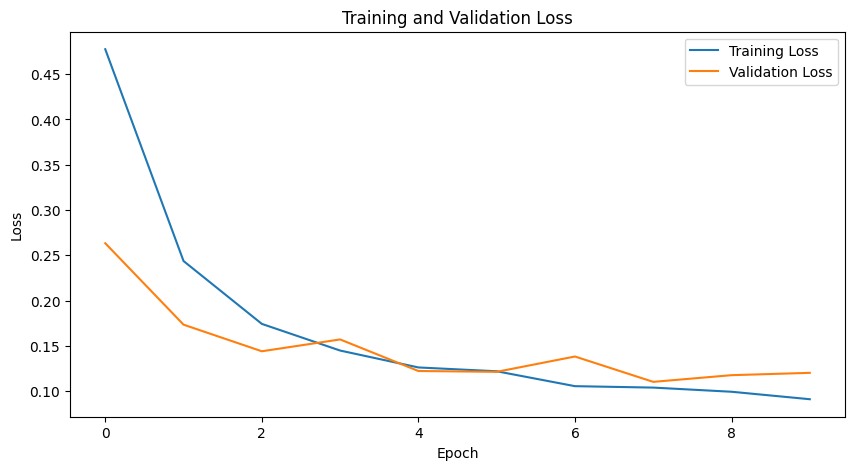

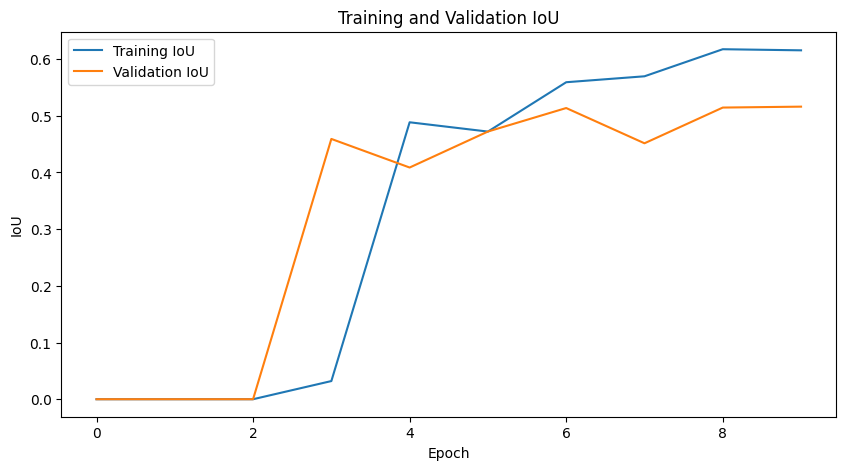

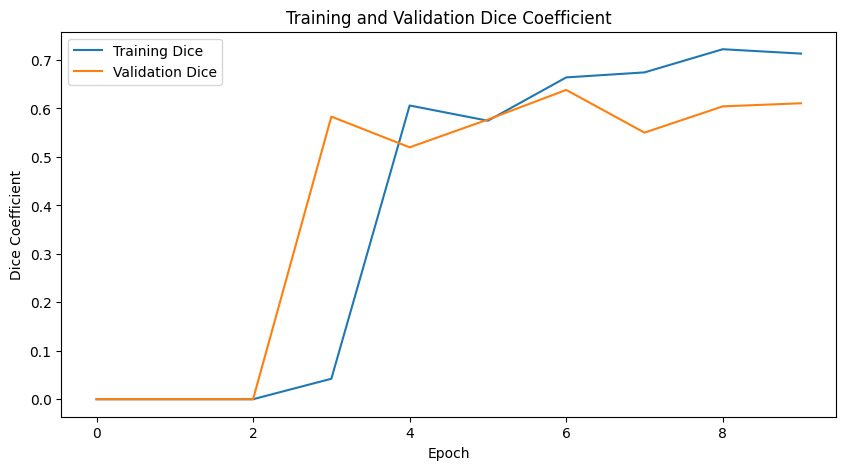

In [12]:
# Training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=2)

In [13]:
def eval_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    total_pixel_acc = 0
    results = []  # Store images, masks, and predictions for visualization

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Threshold predictions at 0.5
            binary_preds = (preds > 0.5).float()

            # Store the results for visualization
            results.append((images.cpu(), masks.cpu(), binary_preds.cpu()))

            # Calculate metrics
            total_iou += iou_score(binary_preds, masks)
            total_dice += dice_coefficient(binary_preds, masks)
            total_precision += precision(binary_preds, masks)
            total_recall += recall(binary_preds, masks)
            total_pixel_acc += pixel_accuracy(binary_preds, masks)

    # Average metrics
    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    avg_precision = total_precision / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_pixel_acc = total_pixel_acc / len(dataloader)
    avg_f1 = f1_score(avg_precision, avg_recall)

    print(f"Final Model Accuracy - IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, "
          f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, "
          f"F1: {avg_f1:.4f}, Pixel Acc: {avg_pixel_acc:.4f}")

    # Log the evaluation metrics as scalars
    wandb.log({
        "eval_iou": avg_iou,
        "eval_dice": avg_dice,
        "eval_precision": avg_precision,
        "eval_recall": avg_recall,
        "eval_f1": avg_f1,
        "eval_pixel_acc": avg_pixel_acc,
    })

    return results  # Return the results for visualization


In [14]:
def visualize_results(results, num_samples=3):
    for i in range(num_samples):
        images, masks, preds = results[i]
        for j in range(images.shape[0]):  # Iterate over batch size
            plt.figure(figsize=(12, 4))
            
            # Calculate metrics
            iou = iou_score(preds[j].unsqueeze(0), masks[j].unsqueeze(0))
            dice = dice_coefficient(preds[j].unsqueeze(0), masks[j].unsqueeze(0))
            
            plt.subplot(1, 3, 1)
            plt.imshow(images[j].permute(1, 2, 0))  # Convert [C, H, W] to [H, W, C]
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(masks[j][0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(preds[j][0], cmap='gray')
            plt.title(f"Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}")
            plt.axis('off')
            
            plt.show()
            if i >= num_samples - 1:
                break


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  7.39it/s]


Final Model Accuracy - IoU: 0.5935, Dice: 0.6929, Precision: 0.7536, Recall: 0.7213, F1: 0.7371, Pixel Acc: 0.9687


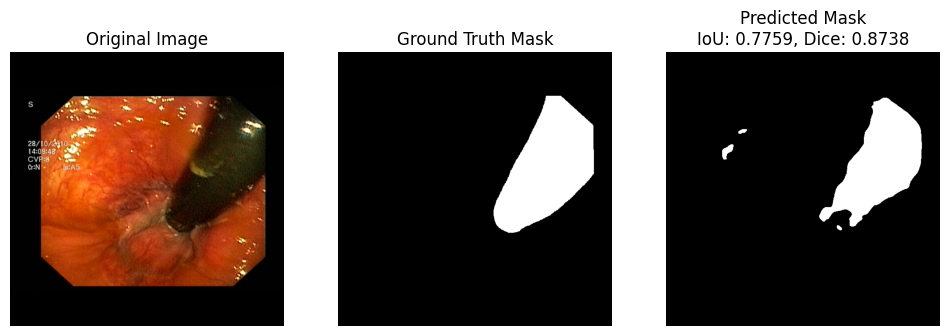

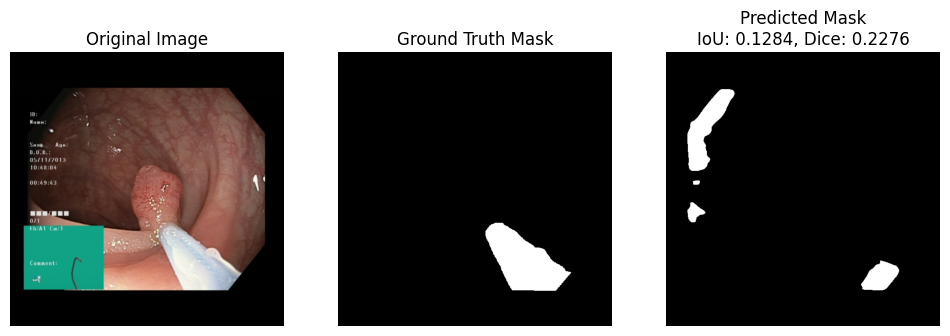

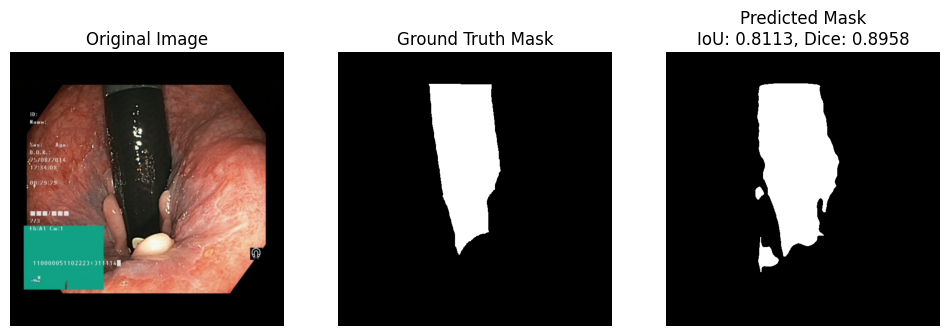

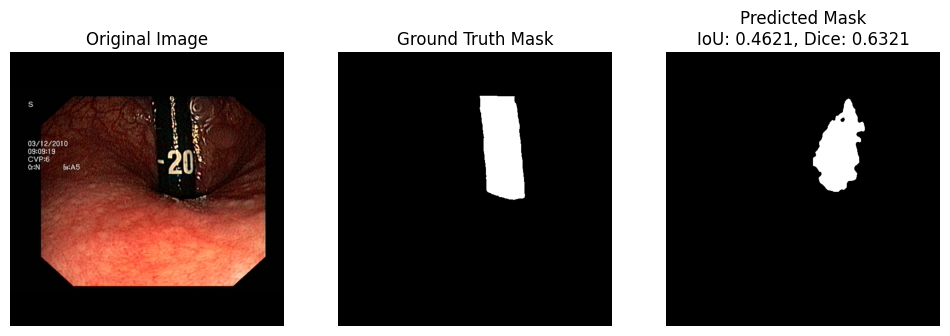

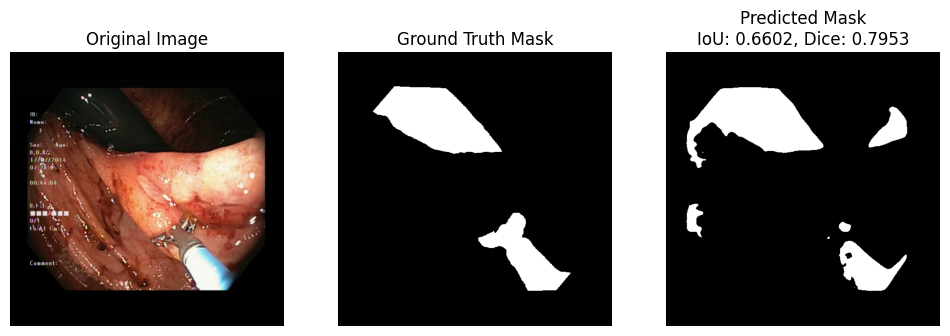

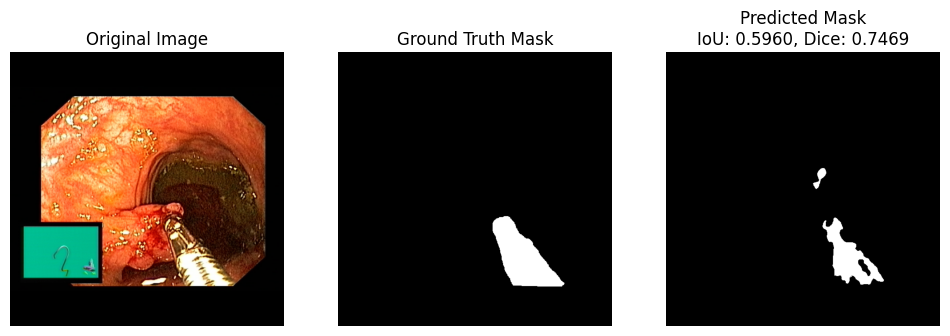

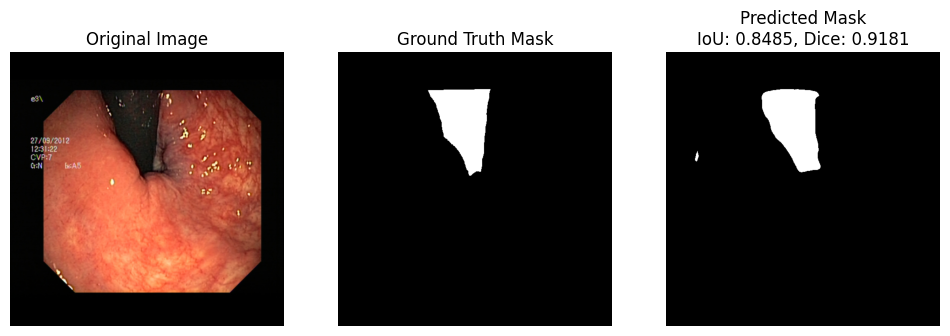

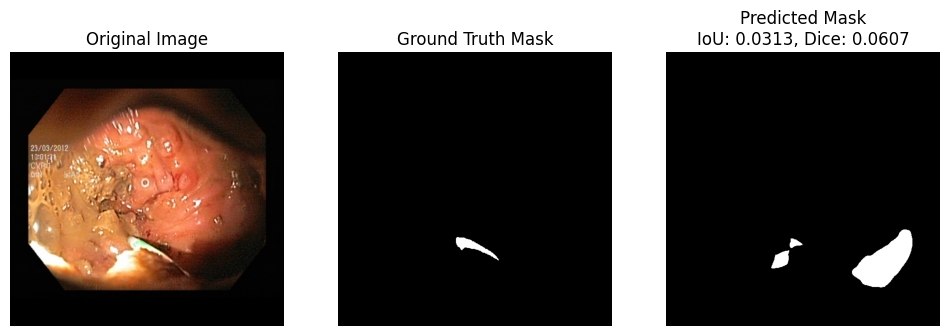

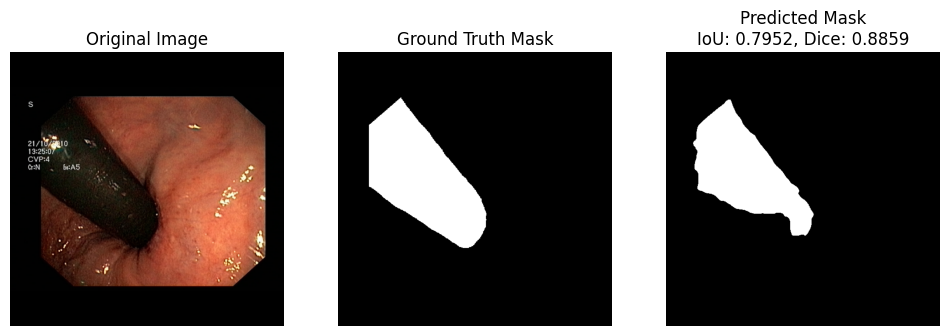

eval_dice,▁
eval_f1,▁
eval_iou,▁
eval_pixel_acc,▁
eval_precision,▁
eval_recall,▁
total_training_time,▁
train_dice,▁▁▁▁▇▇▇███
train_f1,▁▁▁▁▇▇████
train_iou,▁▁▁▁▇▆▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁


In [15]:
# Evaluate the model
results = eval_model(model, test_loader, device)

# Visualize results
visualize_results(results, num_samples=3)
wandb.finish()

In [16]:
# Cleanup Section to Clear Memory with Memory Tracking

import gc
import psutil

# Function to get current memory usage in GB
def get_memory_usage_gb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # Convert bytes to GB

# Memory usage before cleanup
memory_before = get_memory_usage_gb()

# List of variables to delete
vars_to_delete = [
    'model',
    'train_dataset',
    'val_dataset',
    'test_dataset',
    'train_loader',
    'val_loader',
    'test_loader',
    'optimizer',
    'scheduler',
    'criterion',
    'results',
    'preds',
    'binary_preds',
    'outputs',
    'images',
    'masks',
]

for var in vars_to_delete:
    if var in globals():
        del globals()[var]

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Memory usage after cleanup
memory_after = get_memory_usage_gb()

# Display how much memory was cleared
memory_cleared = memory_before - memory_after
print(f"Memory before cleanup: {memory_before:.2f} GB")
print(f"Memory after cleanup: {memory_after:.2f} GB")
print(f"Memory cleared: {memory_cleared:.2f} GB")


Memory before cleanup: 2.40 GB
Memory after cleanup: 2.33 GB
Memory cleared: 0.07 GB
